# Homework of 6th week

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [5]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [6]:
df['median_house_value'] = np.log1p(df.median_house_value)

In [7]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2/(0.2+0.6), random_state=1)
print(len(df_train), len(df_val), len(df_test))
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

12384 4128 4128


In [8]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

Question 1

In [13]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=1,random_state=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [14]:
dt.feature_importances_

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [18]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



* answer ocean_proximity=INLAND

Question 2

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [22]:
from sklearn.metrics import mean_squared_error
def root_mean_squared_error(x,y):
    return mean_squared_error(x,y)**0.5
y_val_hat = rf.predict(X_val)
rmse_val = root_mean_squared_error(y_val,y_val_hat)

In [23]:
rmse_val

0.24579193759466622

* Answer: 0.25

Question 3

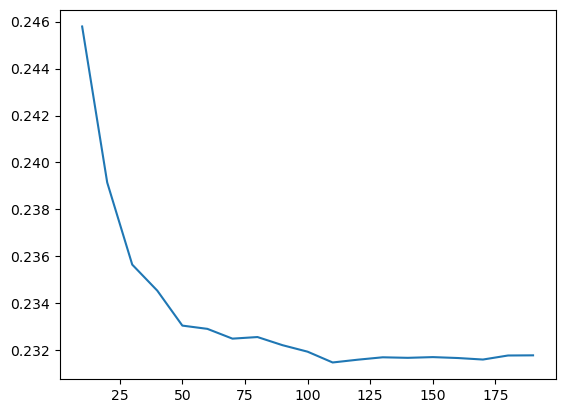

In [32]:
n_estimators_list = list(np.arange(10, 200, 10))
rmse_val_list = []
for n in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_val_hat = rf.predict(X_val)
    rmse_val = root_mean_squared_error(y_val,y_val_hat)
    rmse_val_list.append(rmse_val)

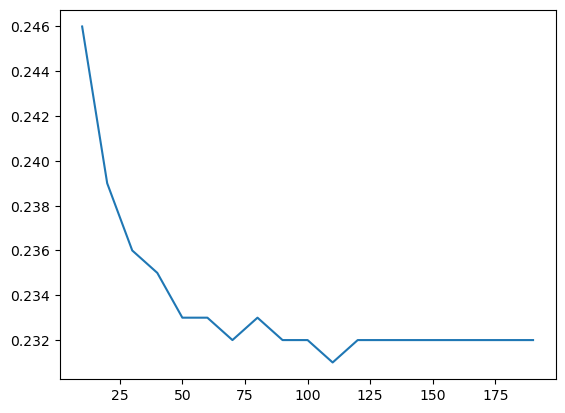

In [55]:
plt.plot(n_estimators_list,np.round(rmse_val_list,3))

* Strictly speaing rmse stops improving after 70

Question 4

In [48]:
max_depth = [10, 15, 20, 25]
rmse_val_2d_list = []
for m in max_depth:
    rmse_val_1d_list = []
    for n in n_estimators_list:
        rf = RandomForestRegressor(max_depth = m,n_estimators=n, random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_hat = rf.predict(X_val)
        rmse_val = root_mean_squared_error(y_val,y_val_hat)
        rmse_val_1d_list.append(rmse_val)
    rmse_val_2d_list.append(rmse_val_1d_list)

10 0
15 1
20 2
25 3


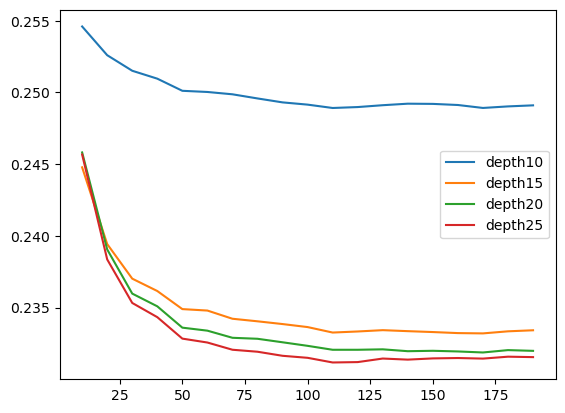

In [52]:
for idx,m in enumerate(max_depth):
    print(m,idx)
    plt.plot(n_estimators_list,rmse_val_2d_list[idx],label="depth"+str(m))
plt.legend()

Answer = best depth 25

Question 5

In [53]:
rf_q5 = RandomForestRegressor(max_depth = 20,n_estimators=10, random_state=1,n_jobs=-1)
rf_q5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [54]:
rf_q5.feature_importances_

array([1.61407558e-02, 3.31967386e-02, 1.01333351e-01, 9.63405488e-02,
       3.63224176e-01, 2.76524800e-03, 3.10900842e-01, 3.56806263e-04,
       4.52770519e-04, 4.45219202e-03, 3.09988869e-02, 1.93726028e-02,
       2.04650818e-02])

In [60]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf_q5.feature_importances_

In [61]:
df_importances[df_importances.importance == max(df_importances.importance)]

,feature,importance
4,median_income,0.363224


Answer: meadian income

Question 6

In [72]:
features = dv.get_feature_names()
print(features)
for idx,feature in enumerate(features):
    features[idx] = features[idx].replace('=<','_leq_')
print(features)

['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximityleq1H_OCEAN', 'ocean_proximity=INLAND', 'ocean_proximity=ISLAND', 'ocean_proximity=NEAR_BAY', 'ocean_proximity=NEAR_OCEAN', 'population', 'total_bedrooms', 'total_rooms']
['households', 'housing_median_age', 'latitude', 'longitude', 'median_income', 'ocean_proximityleq1H_OCEAN', 'ocean_proximity=INLAND', 'ocean_proximity=ISLAND', 'ocean_proximity=NEAR_BAY', 'ocean_proximity=NEAR_OCEAN', 'population', 'total_bedrooms', 'total_rooms']


In [74]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100,evals=watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13245
[1]	train-rmse:5.69586	val-rmse:5.70070
[2]	train-rmse:3.99540	val-rmse:4.00041
[3]	train-rmse:2.80712	val-rmse:2.81079
[4]	train-rmse:1.97834	val-rmse:1.98175
[5]	train-rmse:1.40218	val-rmse:1.40741
[6]	train-rmse:1.00099	val-rmse:1.00700
[7]	train-rmse:0.72751	val-rmse:0.73439
[8]	train-rmse:0.54190	val-rmse:0.55047
[9]	train-rmse:0.42167	val-rmse:0.43233
[10]	train-rmse:0.34481	val-rmse:0.35782
[11]	train-rmse:0.29835	val-rmse:0.31360
[12]	train-rmse:0.27095	val-rmse:0.28865
[13]	train-rmse:0.25268	val-rmse:0.27334
[14]	train-rmse:0.24295	val-rmse:0.26605
[15]	train-rmse:0.23555	val-rmse:0.26044
[16]	train-rmse:0.22630	val-rmse:0.25229
[17]	train-rmse:0.22233	val-rmse:0.24902
[18]	train-rmse:0.22029	val-rmse:0.24826
[19]	train-rmse:0.21791	val-rmse:0.24696
[20]	train-rmse:0.21580	val-rmse:0.24624
[21]	train-rmse:0.21160	val-rmse:0.24334
[22]	train-rmse:0.20975	val-rmse:0.24245
[23]	train-rmse:0.20904	val-rmse:0.24269
[24]	train-rmse:0.20703	va

In [75]:
# now eta = 0.1
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100,evals=watchlist)

[0]	train-rmse:10.44372	val-rmse:10.44938
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46831
[3]	train-rmse:7.61859	val-rmse:7.62391
[4]	train-rmse:6.85878	val-rmse:6.86368
[5]	train-rmse:6.17513	val-rmse:6.17987
[6]	train-rmse:5.55994	val-rmse:5.56437
[7]	train-rmse:5.00643	val-rmse:5.01061
[8]	train-rmse:4.50846	val-rmse:4.51264
[9]	train-rmse:4.06043	val-rmse:4.06461
[10]	train-rmse:3.65741	val-rmse:3.66135
[11]	train-rmse:3.29492	val-rmse:3.29877
[12]	train-rmse:2.96894	val-rmse:2.97284
[13]	train-rmse:2.67573	val-rmse:2.67979
[14]	train-rmse:2.41195	val-rmse:2.41587
[15]	train-rmse:2.17500	val-rmse:2.17928
[16]	train-rmse:1.96214	val-rmse:1.96662
[17]	train-rmse:1.77065	val-rmse:1.77536
[18]	train-rmse:1.59880	val-rmse:1.60396
[19]	train-rmse:1.44376	val-rmse:1.44910
[20]	train-rmse:1.30499	val-rmse:1.31054
[21]	train-rmse:1.18080	val-rmse:1.18646
[22]	train-rmse:1.06879	val-rmse:1.07469
[23]	train-rmse:0.96912	val-rmse:0.97546
[24]	train-rmse:0.87914	

In [ ]:
* eta =0.3 leads to better rmse